In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
seed = 42
np.random.seed(seed)

# Падалко Богдан. Экзаменационная работа по предмету "Основы нейронных сетей".

## Описание выбранного датасета
Для своей экзаменационной работы я выбрал датасет **Pima Indians Diabetes Database** (База данных диабета индейцев пима), расположенный по следующей ссылке:

https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

Данный датасет был подготовлен **Национальным институтом диабета, болезней органов пищеварения и почек (NIDDK), США**.

Целью собранных данных является прогнозирование наличия у пациента диабета на основе диагностических измерений. В качестве испытуемых для данного датасета были выбраны женщины индейского происхождения пима возрастом 21 год и выше.

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Описание признаков (медицинских измерений):

- **Pregnancies** - количество беременностей.
- **Glucose** - концентрация глюкозы в плазме через 2 часа при ПГТТ (Пероральный глюкозотолерантный тест).
- **BloodPressure** - диастолическое артериальное давление (мм рт. ст.).
- **SkinThickness** - толщина кожной складки трицепса (мм).
- **Insulin** - инсулин в сыворотке крови после нагрузки (мкЕд/мл).
- **BMI** - индекс массы тела (кг/м^2).
- **DiabetesPedigreeFunction** - функция диабетической родословной.
- **Age** - возраст.

Описание искомого результата:

**Outcome** - наличие диабета (0 - отсутствует, 1 - имеется).

## Проверка и оптимизация датасета

Перед построением модели необходимо проверить датасет на наличие некорректных значений. Для этого возпользуемся функциями isnull и describe.

In [3]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

В датасете нет NaN-значений.

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Если взглянуть на столбец с минимальными значениями, то становится ясно, что в столбцах **Glucose**, **BloodPressure**, **SkinThickness**, **Insulin** и **BMI** присутствуют нулевые значения, которые невозможны для данных медицинских показателей. Заменим эти значения на NaN.

In [5]:
df_with_nan = df.copy(deep = True)
df_with_nan[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df_with_nan[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0.0, np.NaN)

In [6]:
df_with_nan.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,763.0,121.686763,30.535641,44.000,99.00000,117.0000,141.00000,199.00
BloodPressure,733.0,72.405184,12.382158,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,541.0,29.153420,10.476982,7.000,22.00000,29.0000,36.00000,99.00
Insulin,394.0,155.548223,118.775855,14.000,76.25000,125.0000,190.00000,846.00
BMI,757.0,32.457464,6.924988,18.200,27.50000,32.3000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Посмотрим, сколько значений каждого из столбцов стали NaN.

In [7]:
df_with_nan.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Попробуем заменить отсутствующие значения столбцов средними значениями по данному столбцу с оглядкой на возраст.

In [8]:
repl_pars = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
unique_ages = df_with_nan.Age.unique().tolist()
df_with_nan_unique_age = df_with_nan.copy(deep = True)
for target_age in unique_ages:
    #print("Замена NaN-значений для возраста "+str(target_age)+":")
    for target_par in repl_pars:
        mean_value = df_with_nan_unique_age.loc[df_with_nan_unique_age["Age"] == target_age, target_par].mean()
        df_with_nan_unique_age[target_par] = np.where(df_with_nan_unique_age["Age"] == target_age, mean_value, df_with_nan_unique_age[target_par])
        #print("Столбец "+str(target_par)+" заменён.")

In [9]:
df_with_nan_unique_age.isnull().sum()

Pregnancies                  0
Glucose                      0
BloodPressure                1
SkinThickness               12
Insulin                     20
BMI                          0
DiabetesPedigreeFunction     0
Age                          0
Outcome                      0
dtype: int64

После замены с оглядкой на точный возраст всё ещё остались NaN-значения.

In [10]:
remaining_nans = df_with_nan_unique_age[df_with_nan_unique_age.isna().any(axis = 1)]
remaining_nans

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
123,5,134.000000,81.000000,NaN,NaN,26.800000,0.186,69,0
129,0,139.500000,71.500000,58.0,NaN,28.950000,0.741,62,1
148,5,137.000000,78.666667,37.0,NaN,31.600000,0.218,65,0
221,2,157.000000,86.000000,NaN,NaN,30.375000,0.805,66,1
294,0,137.000000,78.666667,37.0,NaN,31.600000,0.254,65,0
362,5,137.000000,78.666667,37.0,NaN,31.600000,0.305,65,0
363,4,132.333333,72.666667,NaN,NaN,28.766667,0.520,67,1
453,2,119.000000,NaN,NaN,NaN,19.600000,0.832,72,0
456,1,139.500000,71.500000,58.0,NaN,28.950000,0.687,62,0
489,8,132.333333,72.666667,NaN,NaN,28.766667,0.551,67,0


Для всех пациентов с оставшимися NaN-значениями неизвестен параметр **Insulin**, поэтому попробуем взять его значения для данного диапазона возрастов из той части датасета, где он известен.

In [11]:
min_age = remaining_nans.Age.min()
print("Минимальный возраст оставшихся пациентов: "+str(min_age)+".")
max_age = remaining_nans.Age.max()
print("Максимальный возраст оставшихся пациентов: "+str(max_age)+".")

Минимальный возраст оставшихся пациентов: 62.
Максимальный возраст оставшихся пациентов: 72.


In [12]:
possible_insulin = df_with_nan_unique_age.loc[((df_with_nan_unique_age["Age"] <= max_age) & (df_with_nan_unique_age["Age"] >= min_age)), "Insulin"].dropna().unique()
print("Возможные значения столбца Insulin:", possible_insulin)

Возможные значения столбца Insulin: [180.]


Для пацентов в возрасте от 62 до 72 лет в датасете нашлось только одно значение параметра **Insulin** - 180. Поэтому заменим значения NaN данного столбца на 180.

In [13]:
df_with_nan_unique_age["Insulin"] = df_with_nan_unique_age["Insulin"].fillna(possible_insulin[0])

Остальные NaN-значения заменим средними значениями по столбцам из таблицы remaining_nans.

In [14]:
for target_par in repl_pars:
    mean_value = remaining_nans[target_par].mean()
    df_with_nan_unique_age[target_par] = df_with_nan_unique_age[target_par].fillna(mean_value)

In [15]:
df_with_nan_unique_age.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

NaN-значения для всех столбцов были успешно заменены. Скопируем отредактированный датасет в переменную оригинального.

In [16]:
df = df_with_nan_unique_age.copy(deep = True)

## Оптимизация входных данных

Сначала необходимо произвести масштабирование признаков из датасета. Для этого воспользуемся **StandardScaler**.

In [17]:
sc = StandardScaler()
x = df.drop("Outcome", axis = 1).values.astype(float)
y = df["Outcome"]

Так как искомый результат **Outcome** уже представлен бинарно (в виде 0 и 1), то нам не надо его как-то изменять.

## Построение нейронной сети

Для предсказания диабета будет построена модель полносвязной нейронной сети. Для построения модели с наилучшей точностью предсказания необходимо найти оптимальные значения следующих параметров:
- **epochs** - количество эпох при обучении модели.
- **batch_size** - объём данных, подаваемых модели между вычислениями функции потерь.

Как дополнение можно также найти оптимальные значения следующих параметров:
- **optimizer** - название оптимизатора, который будет использован Keras при компиляции модели.
- **kernel_initializer** - название способа начальной инициализации весов нейронов.
- **activation** - название способа активации нейронов.

Разделим датасет на тренировочную, тестовую и валидационную выборки. Будем использовать следующее соотношение размеров выборок:
- Тренировочная выборка - 75%.
- Валидационная выборка - 15%.
- Тестовая выборка - 10%.

In [18]:
train_ratio = 0.75
valid_ratio = 0.15
test_ratio = 0.1
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1.0-train_ratio, random_state = seed)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size = test_ratio/(test_ratio+valid_ratio), random_state = seed)

Произведём масштабирование признаков - воспользуемся **StandardScaler**.

In [19]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_valid = sc.transform(x_valid)
x = sc.transform(x)

Я собираюсь попробовать несколько топологий нейронной сети, поэтому напишу одну общую функцию для построения оптимальной модели и использую её на нескольких вариантах полносвязной нейронной сети. У всех вариантов будет один общий слой - слой вывода, состоящий из одного нейрона с сигмоидной (**sigmoid**) активацией, а также общая функция потерь - бинарная кросс-энтропия (**loss = "binary_crossentropy"**) и общая метрика - точность (**metrics = ["accuracy"]**).

In [20]:
def get_best_model_params(model_func, n_splits, known_pars, potential_pars):
    '''
    Поиск лучших параметров для модели model_func среди потенциальных параметров potential_pars при том, что известны параметры known_pars и количество разделений для KFold n_splits.
    '''
    model_kfold = KFold(n_splits = n_splits, shuffle = True, random_state = seed)
    model_classifier = KerasClassifier(model = model_func, verbose = 0, **known_pars)
    model_grid = GridSearchCV(estimator = model_classifier, param_grid = potential_pars, cv = model_kfold, verbose = 1)
    model_grid_result = model_grid.fit(x_train, y_train, validation_data = (x_valid, y_valid), verbose = 0)
    return model_grid_result.best_params_, model_grid_result.best_score_

In [21]:
def get_all_best_seq_model_params(model_func, do_all_at_once = False):
    '''
    Поиск наилучших параметров для модели model_func.
    '''
    n_splits = 10
    current_pars = {}
    current_pars.update({"epochs": 10})
    current_pars.update({"batch_size": 16})
    current_pars.update({"optimizer": "adam"})
    current_pars.update({"activation": "relu"})
    current_pars.update({"init": "normal"})
    epoches = [5, 10, 20, 50, 100]
    batches = [16, 32, 64, 128]
    optimrs = ["rmsprop", "adam", "sgd"]
    actives = ["softmax", "relu", "tanh", "linear"]
    inities = ["uniform", "normal", "zero"]
    potential_pars = {}
    if (do_all_at_once):
        #Ищем сразу все параметры. Это 720 вариаций, ещё умножить на n_splits для KFold.
        print("Поиск всех параметров.")
        potential_pars.update({"epochs": epoches})
        potential_pars.update({"batch_size": batches})
        potential_pars.update({"activation": actives})
        potential_pars.update({"init": inities})
        potential_pars.update({"optimizer": optimrs})
        print("Параметры для модели в данный момент:", current_pars)
        print("Потенциальные параметры для модели:", potential_pars)
        best_potential_pars, best_score = get_best_model_params(model_func, n_splits, current_pars, potential_pars)
        current_pars.update(best_potential_pars)
        return current_pars, best_score
    #Шаг 1 - ищем параметры epochs и batch_size.
    potential_pars.update({"epochs": epoches})
    potential_pars.update({"batch_size": batches})
    print("Шаг 1 - поиск epochs и batch_size.")
    print("Параметры для модели в данный момент:", current_pars)
    print("Потенциальные параметры для модели:", potential_pars)
    best_potential_pars, best_score = get_best_model_params(model_func, n_splits, current_pars, potential_pars)
    current_pars.update(best_potential_pars)
    #Шаг 2 - ищем параметры activation и init.
    potential_pars = {}
    potential_pars.update({"activation": actives})
    potential_pars.update({"init": inities})
    print("Шаг 2 - поиск activation и init.")
    print("Параметры для модели в данный момент:", current_pars)
    print("Потенциальные параметры для модели:", potential_pars)
    best_potential_pars, best_score = get_best_model_params(model_func, n_splits, current_pars, potential_pars)
    current_pars.update(best_potential_pars)
    #Шаг 3 - ищем параметр optimizer.
    potential_pars = {}
    potential_pars.update({"optimizer": optimrs})
    print("Шаг 3 - поиск optimizer.")
    print("Параметры для модели в данный момент:", current_pars)
    print("Потенциальные параметры для модели:", potential_pars)
    best_potential_pars, best_score = get_best_model_params(model_func, n_splits, current_pars, potential_pars)
    current_pars.update(best_potential_pars)
    return current_pars, best_score

### Первый вариант модели

In [22]:
def pima_model_seq1(init = "normal", optimizer = "adam", activation = "relu"):
    model = Sequential()
    model.add(Dense(8, input_dim = x.shape[1], kernel_initializer = init, activation = activation))
    model.add(Dense(16, kernel_initializer = init, activation = activation))
    model.add(Dense(8, kernel_initializer = init, activation = activation))
    model.add(Dense(1, kernel_initializer = init, activation = "sigmoid"))
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model

In [23]:
best_pars_seq1, best_score_seq1 = get_all_best_seq_model_params(pima_model_seq1)

Шаг 1 - поиск epochs и batch_size.
Параметры для модели в данный момент: {'epochs': 10, 'batch_size': 16, 'optimizer': 'adam', 'activation': 'relu', 'init': 'normal'}
Потенциальные параметры для модели: {'epochs': [5, 10, 20, 50, 100], 'batch_size': [16, 32, 64, 128]}
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Шаг 2 - поиск activation и init.
Параметры для модели в данный момент: {'epochs': 50, 'batch_size': 32, 'optimizer': 'adam', 'activation': 'relu', 'init': 'normal'}
Потенциальные параметры для модели: {'activation': ['softmax', 'relu', 'tanh', 'linear'], 'init': ['uniform', 'normal', 'zero']}
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Шаг 3 - поиск optimizer.
Параметры для модели в данный момент: {'epochs': 50, 'batch_size': 32, 'optimizer': 'adam', 'activation': 'tanh', 'init': 'uniform'}
Потенциальные параметры для модели: {'optimizer': ['rmsprop', 'adam', 'sgd']}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


Лучшие параметры для первого варианта модели: {'epochs': 50, 'batch_size': 32, 'optimizer': 'adam', 'activation': 'tanh', 'init': 'uniform'}
Средняя точность: 0.6958257713248639
Epoch 1/50
18/18 [==============================] - 1s 8ms/step - loss: 0.6914 - accuracy: 0.6562 - val_loss: 0.6893 - val_accuracy: 0.6522
Epoch 2/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6858 - accuracy: 0.6545 - val_loss: 0.6818 - val_accuracy: 0.6522
Epoch 3/50
18/18 [==============================] - 0s 3ms/step - loss: 0.6717 - accuracy: 0.6545 - val_loss: 0.6639 - val_accuracy: 0.6435
Epoch 4/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6398 - accuracy: 0.6962 - val_loss: 0.6360 - val_accuracy: 0.6783
Epoch 5/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6062 - accuracy: 0.6892 - val_loss: 0.6214 - val_accuracy: 0.6609
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: 0.5881 - accuracy: 0.6910 - val_loss: 0.6182 - val

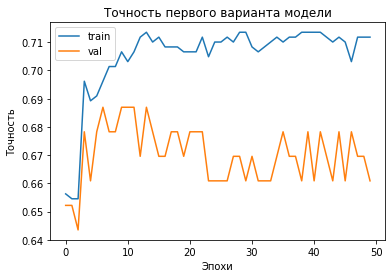

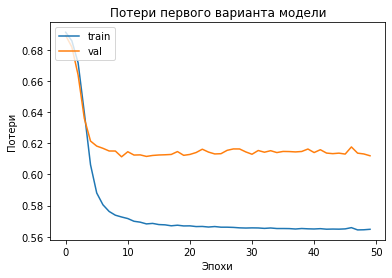

In [24]:
print("Лучшие параметры для первого варианта модели:", best_pars_seq1)
print("Средняя точность:", best_score_seq1)
best_model_seq1 = pima_model_seq1(init = best_pars_seq1["init"], optimizer = best_pars_seq1["optimizer"], activation = best_pars_seq1["activation"])
best_history_seq1 = best_model_seq1.fit(x_train, y_train, epochs = best_pars_seq1["epochs"], batch_size = best_pars_seq1["batch_size"], validation_data = (x_valid, y_valid), verbose = 1)
y_pred = best_model_seq1.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype("int32")
seq1_accuracy = accuracy_score(y_test, y_pred_binary)
print("Точность прогнозирования: "+str(seq1_accuracy*100.0)+"%.")
plt.figure()
plt.plot(best_history_seq1.history['accuracy'])
plt.plot(best_history_seq1.history['val_accuracy'])
plt.title("Точность первого варианта модели")
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.legend(["train", "val"], loc = "upper left")
plt.show()
plt.figure()
plt.plot(best_history_seq1.history['loss'])
plt.plot(best_history_seq1.history['val_loss'])
plt.title("Потери первого варианта модели")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend(["train", "val"], loc = "upper left")
plt.show()

### Второй вариант модели

In [25]:
def pima_model_seq2(init = "normal", optimizer = "adam", activation = "relu"):
    model = Sequential()
    model.add(Dense(16, input_dim = x.shape[1], kernel_initializer = init, activation = activation))
    model.add(Dense(8, kernel_initializer = init, activation = activation))
    model.add(Dense(4, kernel_initializer = init, activation = activation))
    model.add(Dense(1, kernel_initializer = init, activation = 'sigmoid'))
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model

In [26]:
best_pars_seq2, best_score_seq2 = get_all_best_seq_model_params(pima_model_seq2)

Шаг 1 - поиск epochs и batch_size.
Параметры для модели в данный момент: {'epochs': 10, 'batch_size': 16, 'optimizer': 'adam', 'activation': 'relu', 'init': 'normal'}
Потенциальные параметры для модели: {'epochs': [5, 10, 20, 50, 100], 'batch_size': [16, 32, 64, 128]}
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Шаг 2 - поиск activation и init.
Параметры для модели в данный момент: {'epochs': 50, 'batch_size': 16, 'optimizer': 'adam', 'activation': 'relu', 'init': 'normal'}
Потенциальные параметры для модели: {'activation': ['softmax', 'relu', 'tanh', 'linear'], 'init': ['uniform', 'normal', 'zero']}
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Шаг 3 - поиск optimizer.
Параметры для модели в данный момент: {'epochs': 50, 'batch_size': 16, 'optimizer': 'adam', 'activation': 'relu', 'init': 'normal'}
Потенциальные параметры для модели: {'optimizer': ['rmsprop', 'adam', 'sgd']}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


Лучшие параметры для второго варианта модели: {'epochs': 50, 'batch_size': 16, 'optimizer': 'rmsprop', 'activation': 'relu', 'init': 'normal'}
Средняя точность при кросс-валидации 0.697731397459165
Epoch 1/50
36/36 [==============================] - 1s 5ms/step - loss: 0.6903 - accuracy: 0.6424 - val_loss: 0.6877 - val_accuracy: 0.6522
Epoch 2/50
36/36 [==============================] - 0s 2ms/step - loss: 0.6856 - accuracy: 0.6545 - val_loss: 0.6835 - val_accuracy: 0.6522
Epoch 3/50
36/36 [==============================] - 0s 2ms/step - loss: 0.6811 - accuracy: 0.6545 - val_loss: 0.6788 - val_accuracy: 0.6522
Epoch 4/50
36/36 [==============================] - 0s 2ms/step - loss: 0.6753 - accuracy: 0.6545 - val_loss: 0.6724 - val_accuracy: 0.6522
Epoch 5/50
36/36 [==============================] - 0s 2ms/step - loss: 0.6674 - accuracy: 0.6545 - val_loss: 0.6633 - val_accuracy: 0.6522
Epoch 6/50
36/36 [==============================] - 0s 2ms/step - loss: 0.6538 - accuracy: 0.6545 - va

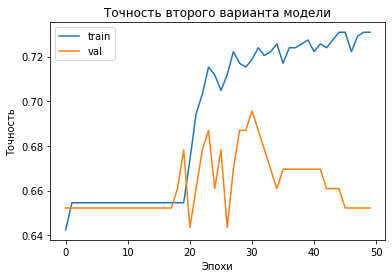

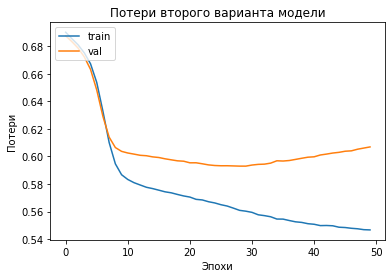

In [27]:
print("Лучшие параметры для второго варианта модели:", best_pars_seq2)
print("Средняя точность при кросс-валидации", best_score_seq2)
best_model_seq2 = pima_model_seq2(init = best_pars_seq2["init"], optimizer = best_pars_seq2["optimizer"], activation = best_pars_seq2["activation"])
best_history_seq2 = best_model_seq2.fit(x_train, y_train, epochs = best_pars_seq2["epochs"], batch_size = best_pars_seq2["batch_size"], validation_data = (x_valid, y_valid), verbose = 1)
y_pred = best_model_seq2.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype("int32")
seq2_accuracy = accuracy_score(y_test, y_pred_binary)
print("Точность прогнозирования: "+str(seq2_accuracy*100.0)+"%.")
plt.figure()
plt.plot(best_history_seq2.history['accuracy'])
plt.plot(best_history_seq2.history['val_accuracy'])
plt.title("Точность второго варианта модели")
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.legend(["train", "val"], loc = "upper left")
plt.show()
plt.figure()
plt.plot(best_history_seq2.history['loss'])
plt.plot(best_history_seq2.history['val_loss'])
plt.title("Потери второго варианта модели")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend(["train", "val"], loc = "upper left")
plt.show()

### Третий вариант модели

In [28]:
def pima_model_seq3(init = "normal", optimizer = "adam", activation = "relu"):
    model = Sequential()
    model.add(Dense(8, input_dim = x.shape[1], kernel_initializer = init, activation = activation))
    model.add(Dense(4, kernel_initializer = init, activation = activation))
    model.add(Dense(1, kernel_initializer = init, activation = "sigmoid"))
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model

In [29]:
best_pars_seq3, best_score_seq3 = get_all_best_seq_model_params(pima_model_seq3)

Шаг 1 - поиск epochs и batch_size.
Параметры для модели в данный момент: {'epochs': 10, 'batch_size': 16, 'optimizer': 'adam', 'activation': 'relu', 'init': 'normal'}
Потенциальные параметры для модели: {'epochs': [5, 10, 20, 50, 100], 'batch_size': [16, 32, 64, 128]}
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Шаг 2 - поиск activation и init.
Параметры для модели в данный момент: {'epochs': 100, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'relu', 'init': 'normal'}
Потенциальные параметры для модели: {'activation': ['softmax', 'relu', 'tanh', 'linear'], 'init': ['uniform', 'normal', 'zero']}
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Шаг 3 - поиск optimizer.
Параметры для модели в данный момент: {'epochs': 100, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'linear', 'init': 'normal'}
Потенциальные параметры для модели: {'optimizer': ['rmsprop', 'adam', 'sgd']}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


Лучшие параметры для третьего варианта модели: {'epochs': 100, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'linear', 'init': 'normal'}
Средняя точность при кросс-валидации: 0.6941016333938295
Epoch 1/100
9/9 [==============================] - 0s 15ms/step - loss: 0.6912 - accuracy: 0.6267 - val_loss: 0.6891 - val_accuracy: 0.6522
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.6545 - val_loss: 0.6859 - val_accuracy: 0.6522
Epoch 3/100
9/9 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.6580 - val_loss: 0.6822 - val_accuracy: 0.6609
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.6667 - val_loss: 0.6777 - val_accuracy: 0.6696
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 0.6737 - accuracy: 0.6753 - val_loss: 0.6724 - val_accuracy: 0.6870
Epoch 6/100
9/9 [==============================] - 0s 4ms/step - loss: 0.6669 - accuracy: 0.6753 - v

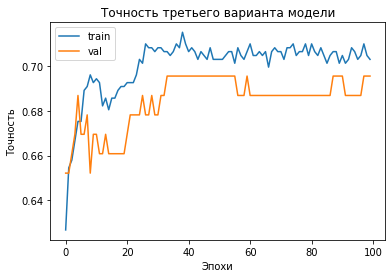

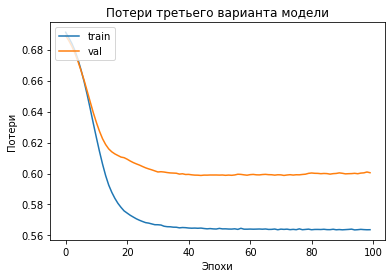

In [30]:
print("Лучшие параметры для третьего варианта модели:", best_pars_seq3)
print("Средняя точность при кросс-валидации:", best_score_seq3)
best_model_seq3 = pima_model_seq3(init = best_pars_seq3["init"], optimizer = best_pars_seq3["optimizer"], activation = best_pars_seq3["activation"])
best_history_seq3 = best_model_seq3.fit(x_train, y_train, epochs = best_pars_seq3["epochs"], batch_size = best_pars_seq3["batch_size"], validation_data = (x_valid, y_valid), verbose = 1)
y_pred = best_model_seq3.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype("int32")
seq3_accuracy = accuracy_score(y_test, y_pred_binary)
print("Точность прогнозирования: "+str(seq3_accuracy*100.0)+"%.")
plt.figure()
plt.plot(best_history_seq3.history['accuracy'])
plt.plot(best_history_seq3.history['val_accuracy'])
plt.title("Точность третьего варианта модели")
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.legend(["train", "val"], loc = "upper left")
plt.show()
plt.figure()
plt.plot(best_history_seq3.history['loss'])
plt.plot(best_history_seq3.history['val_loss'])
plt.title("Потери третьего варианта модели")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend(["train", "val"], loc = "upper left")
plt.show()

### Четвёртый вариант модели

In [31]:
def pima_model_seq4(init = "normal", optimizer = "adam", activation = "relu"):
    model = Sequential()
    model.add(Dense(64, input_dim = x.shape[1], kernel_initializer = init, activation = activation))
    model.add(Dense(32, kernel_initializer = init, activation = activation))
    model.add(Dense(16, kernel_initializer = init, activation = activation))
    model.add(Dense(64, kernel_initializer = init, activation = activation))
    model.add(Dense(1, kernel_initializer = init, activation = "sigmoid"))
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model

In [32]:
best_pars_seq4, best_score_seq4 = get_all_best_seq_model_params(pima_model_seq4)

Шаг 1 - поиск epochs и batch_size.
Параметры для модели в данный момент: {'epochs': 10, 'batch_size': 16, 'optimizer': 'adam', 'activation': 'relu', 'init': 'normal'}
Потенциальные параметры для модели: {'epochs': [5, 10, 20, 50, 100], 'batch_size': [16, 32, 64, 128]}
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Шаг 2 - поиск activation и init.
Параметры для модели в данный момент: {'epochs': 10, 'batch_size': 32, 'optimizer': 'adam', 'activation': 'relu', 'init': 'normal'}
Потенциальные параметры для модели: {'activation': ['softmax', 'relu', 'tanh', 'linear'], 'init': ['uniform', 'normal', 'zero']}
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Шаг 3 - поиск optimizer.
Параметры для модели в данный момент: {'epochs': 10, 'batch_size': 32, 'optimizer': 'adam', 'activation': 'tanh', 'init': 'normal'}
Потенциальные параметры для модели: {'optimizer': ['rmsprop', 'adam', 'sgd']}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


Лучшие параметры для четвёртого варианта модели: {'epochs': 10, 'batch_size': 32, 'optimizer': 'sgd', 'activation': 'tanh', 'init': 'normal'}
Средняя точность при кросс-валидации: 0.7010284331518453
Epoch 1/10
18/18 [==============================] - 0s 8ms/step - loss: 0.6911 - accuracy: 0.6319 - val_loss: 0.6886 - val_accuracy: 0.6522
Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.6545 - val_loss: 0.6844 - val_accuracy: 0.6522
Epoch 3/10
18/18 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.6545 - val_loss: 0.6806 - val_accuracy: 0.6522
Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.6788 - accuracy: 0.6545 - val_loss: 0.6772 - val_accuracy: 0.6522
Epoch 5/10
18/18 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.6545 - val_loss: 0.6741 - val_accuracy: 0.6522
Epoch 6/10
18/18 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.6545 - v

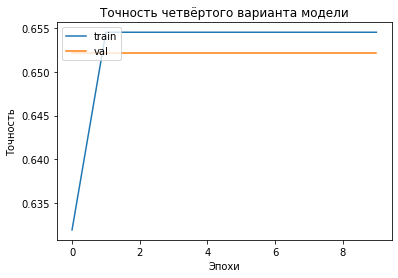

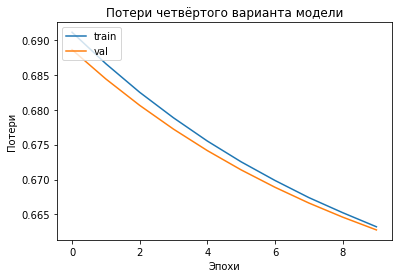

In [33]:
print("Лучшие параметры для четвёртого варианта модели:", best_pars_seq4)
print("Средняя точность при кросс-валидации:", best_score_seq4)
best_model_seq4 = pima_model_seq4(init = best_pars_seq4["init"], optimizer = best_pars_seq4["optimizer"], activation = best_pars_seq4["activation"])
best_history_seq4 = best_model_seq4.fit(x_train, y_train, epochs = best_pars_seq4["epochs"], batch_size = best_pars_seq4["batch_size"], validation_data = (x_valid, y_valid), verbose = 1)
y_pred = best_model_seq4.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype("int32")
seq4_accuracy = accuracy_score(y_test, y_pred_binary)
print("Точность прогнозирования: "+str(seq4_accuracy*100.0)+"%.")
plt.figure()
plt.plot(best_history_seq4.history['accuracy'])
plt.plot(best_history_seq4.history['val_accuracy'])
plt.title("Точность четвёртого варианта модели")
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.legend(["train", "val"], loc = "upper left")
plt.show()
plt.figure()
plt.plot(best_history_seq4.history['loss'])
plt.plot(best_history_seq4.history['val_loss'])
plt.title("Потери четвёртого варианта модели")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend(["train", "val"], loc = "upper left")
plt.show()

### Прогнозирование методом "случайного леса"

Воспользуемся для прогнозирования также методом "случайного леса" - составим новую модель с использованием **RandomForestClassifier** и того же **GridSearchCV** для подбора гиперпараметров.

Будем подбирать следующие параметры:
- **n_estimators** - количество деревьев в лесу.
- **max_features** - количество признаков для выбора разделения.
- **max_depth** - максимальная глубина дерева.
- **criterion** - название функции для измерения качества разделения.

In [34]:
def get_best_randomforest_model_params(n_splits, known_pars, potential_pars):
    '''
    Поиск лучших параметров для модели RandomForestClassifier среди потенциальных параметров potential_pars при том, что известны параметры known_pars и количество разделений для KFold n_splits.
    '''
    model_kfold = KFold(n_splits = n_splits, shuffle = True, random_state = seed)
    model_classifier = RandomForestClassifier(random_state = seed)
    model_grid = GridSearchCV(estimator = model_classifier, param_grid = potential_pars, cv = model_kfold, verbose = 1)
    model_grid_result = model_grid.fit(x_train, y_train)
    return model_grid_result.best_params_, model_grid_result.best_score_

In [35]:
def get_all_best_randomforest_model_params():
    n_splits = 10
    estims = [100, 200, 500]
    maxfea = ["sqrt", "log2"]
    mdepth = [4, 8, 10]
    criter = ["gini", "entropy", "log_loss"]
    current_pars = {}
    current_pars.update({"n_estimators": 100})
    current_pars.update({"max_features": "sqrt"})
    current_pars.update({"max_depth": 10})
    current_pars.update({"criterion": "gini"})
    potential_pars = {}
    potential_pars.update({"n_estimators": estims})
    potential_pars.update({"max_features": maxfea})
    potential_pars.update({"max_depth": mdepth})
    potential_pars.update({"criterion": criter})
    #Ищем сразу все параметры. Это 54 вариации, ещё умножить на n_splits для KFold.
    print("Поиск всех параметров.")
    print("Потенциальные параметры для модели:", potential_pars)
    best_potential_pars, best_score = get_best_randomforest_model_params(n_splits, current_pars, potential_pars)
    return best_potential_pars, best_score

In [36]:
best_pars_randomforest, best_score_randomforest = get_all_best_randomforest_model_params()

Поиск всех параметров.
Потенциальные параметры для модели: {'n_estimators': [100, 200, 500], 'max_features': ['sqrt', 'log2'], 'max_depth': [4, 8, 10], 'criterion': ['gini', 'entropy', 'log_loss']}
Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [37]:
print("Лучшие параметры для случайного леса:", best_pars_randomforest)
print("Средняя точность при кросс-валидации:", best_score_randomforest)
best_model_randomforest = RandomForestClassifier(n_estimators = best_pars_randomforest["n_estimators"], max_features = best_pars_randomforest["max_features"], max_depth = best_pars_randomforest["max_depth"], criterion = best_pars_randomforest["criterion"], random_state = seed)
best_model_randomforest.fit(x_train, y_train)
y_pred = best_model_randomforest.predict(x_test)
randomforest_accuracy = accuracy_score(y_test, y_pred)
print("Точность прогнозирования: "+str(randomforest_accuracy*100.0)+"%.")

Лучшие параметры для случайного леса: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 200}
Средняя точность при кросс-валидации: 0.6820024198427103
Точность прогнозирования: 63.63636363636363%.


## Вывод

Я расмотрел 4 модели полносвязных нейронных сетей различной топологии и модель "случайного леса" для прогнозирования диабета индейцев пима на основе медицинских показателей. Средняя точность сгенерированных моделей составила в районе 62-66%, что не является высоким результатом. Однако это можно оправдать тем, что изначальные данные были предоставлены не в полном виде - часть из них необходимо было заменить на более близкие к действительности, а также тем, что поиск гиперпараметров для обучения - это долгий процесс. В том случае, если бы я воспользовался поиском одновременно всех 5 параметров нейросети, для этого потребовалось бы сгенерировать 7200 её вариантов. В то время как при разделении параметров по группам в количестве 2-2-1 потребовалось в сумме лишь 350 вариантов нейросети.

При желании для полносвязных сетей можно изменить ряд возможных значений параметров **batch_size** и **epochs** и повысить точность обучения. Однако это может повлечь за собой переобучение.

Для "случайного леса" можно также поменять ряды возможных параметров, в частности увеличить численные параметры **n_estimators** и **max_depth** и получить возможно более точную модель.